In [50]:
%matplotlib inline 

from lattice_generation import GeneratedLatticeImage

## Generate Data

Specify parameters to generate data:

In [51]:
N = 5 #Number of lattice sites along each axis
M = 10 #Number of pixels per lattice site
N_atom = 12 #Number of atoms to be randomly placed
N_photon = 100 #Number of photons atoms fluoresce
std = 1 #Width of the normal distribution that counts are sampled from
N_backg = 300 #Number of samples drawn from the Poisson distribution for the background noise
lam_backg = 1 #Expectation interval of the Poisson dark count event

Generate the data with specified parameters

In [52]:
lattice_image = GeneratedLatticeImage(
    N=N,
    M=M,
    N_atom=N_atom,
    N_photon=N_photon,
    std=std,
    N_backg=N_backg, 
    lam_backg=lam_backg
)

Visualize the generated data

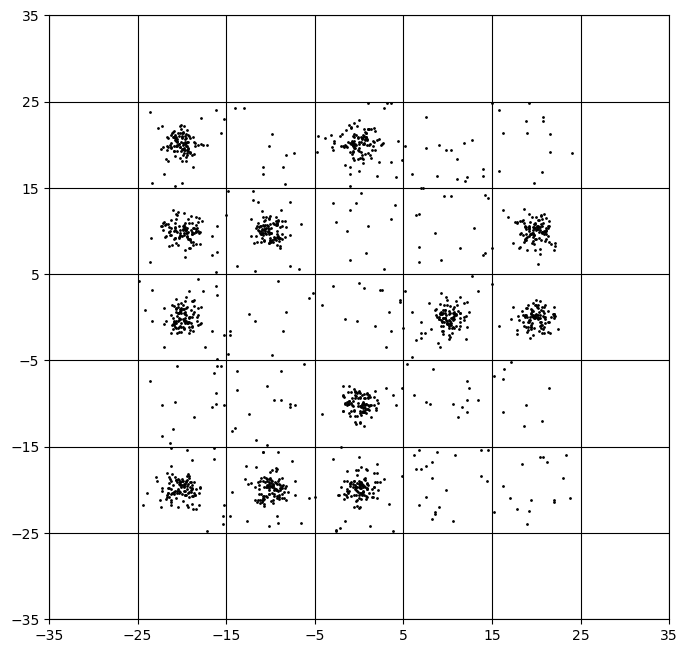

In [53]:
lattice_image.plot()

Generated data also gives the actual, binary distribution of atoms on the lattice

In [54]:
lattice_image.actual_lattice

array([[1., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1.],
       [1., 0., 0., 1., 1.],
       [0., 0., 1., 0., 0.],
       [1., 1., 1., 0., 0.]])

## Analysis Part

In [55]:
from analysis_models import mixture_model_v0
from lattice_analyser import LatticeImageAnalyzer

Specify the model for the analysis, analyze the data with that model given the generated data results

In [56]:
# Instanciate the Analyser with the lattice_image object created above
P = LatticeImageAnalyzer(lattice_image)

# Choose analysis function
analysis_function = mixture_model_v0

# Run analysis
P.run_analysis(
    analysis_function=analysis_function
)

logp = -391.64, ||grad|| = 28.615: 100%|███████████████████████████████████████████████| 8/8 [00:00<00:00, 1145.87it/s]
logp = -46.276, ||grad|| = 1.8392: 100%|███████████████████████████████████████████████| 8/8 [00:00<00:00, 4012.73it/s]
logp = -456.52, ||grad|| = 18.951: 100%|███████████████████████████████████████████████| 7/7 [00:00<00:00, 2340.38it/s]
logp = -78.909, ||grad|| = 3.574: 100%|████████████████████████████████████████████████| 8/8 [00:00<00:00, 2703.39it/s]
logp = -59.87, ||grad|| = 0.0030306: 100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 4210.34it/s]
logp = -391.63, ||grad|| = 25.442: 100%|███████████████████████████████████████████████| 9/9 [00:00<00:00, 4427.48it/s]
logp = -380.61, ||grad|| = 29.832: 100%|███████████████████████████████████████████████| 8/8 [00:00<00:00, 2671.32it/s]
logp = -58.26, ||grad|| = 3.2517: 100%|██████████████████████████████████████████████| 11/11 [00:00<00:00, 3675.11it/s]
logp = -78.288, ||grad|| = 5.3927e-06: 1

The model yields the probability that each lattice site is occupied by an atom

In [57]:
P.print_occupation()

[[88.  18.9 77.4 18.9  0. ]
 [89.5 88.9  5.4  0.  96.2]
 [85.4  0.   4.2 84.8 98.6]
 [ 0.  11.4 94.5 21.1  4.4]
 [84.6 82.6 85.   0.   0. ]]


Compare this result with the actual distribution of atoms

In [58]:
lattice_image.actual_lattice

array([[1., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1.],
       [1., 0., 0., 1., 1.],
       [0., 0., 1., 0., 0.],
       [1., 1., 1., 0., 0.]])